# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [28]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib pandas --upgrade --quiet
!pip install jovian --upgrade --quiet
!pip install seaborn

Solving environment: done

# All requested packages already installed.



In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [30]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [31]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [32]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [33]:
your_name = "QuentinM" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [34]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [35]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
696,53,female,37.7910,2,no,northeast,29478.347184
826,56,male,37.1943,2,yes,southeast,44252.004761
1115,55,male,38.2239,1,no,southeast,10915.561163
823,44,female,34.8777,2,no,southeast,8301.395939
1173,38,male,34.2342,2,no,northwest,6522.421834


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [36]:
# The shape attribute of pandas.DataFrame stores the number of rows and columns as a tuple (number of rows, number of columns).
# Reference: https://note.nkmk.me/en/python-pandas-len-shape-size/
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [37]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [38]:
excluded_cols = ['charges']
input_cols = [e for e in dataframe.columns if e not in excluded_cols] 
print(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker', 'region']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [39]:
# Select Pandas columns by dtype
# 
categorical_cols = dataframe.select_dtypes(exclude=['int', 'float']).columns.values

**Q: What are the column titles of output/target variable(s)?**

In [40]:
output_cols = np.array(['charges'], dtype='object')
print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

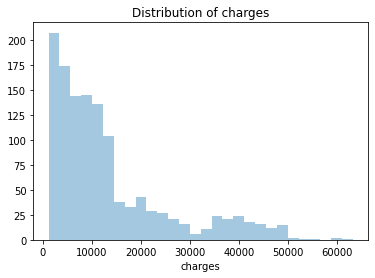

In [41]:
# Write your answer here
min_charges = dataframe.charges.min() # equivalent of min(dataframe.charges)
max_charges = dataframe.charges.max() # equivalent of max(dataframe.charges)
avg_charges = dataframe.charges.mean()
plt.title("Distribution of charges")
sns.distplot(dataframe.charges, kde=False);

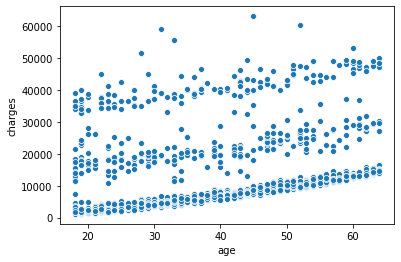

In [42]:
sns.scatterplot(dataframe.age, dataframe.charges)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [43]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "quentinmadura/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/quentinmadura/02-insurance-linear-regression


'https://jovian.ml/quentinmadura/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [44]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outpts as numpy arrays
    breakpoint
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [45]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [46]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

In [47]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [48]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [62]:
val_percent = 0.15
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size]) 

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [61]:
batch_size = 64

In [51]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [73]:
for xb, yb in train_loader:
    outputs = model(xb)
    break
    
print("Sample outputs:", outputs[:2].data )

Sample outputs: tensor([[20036.9590],
        [ 9009.7725]])


Let's save our work by committing to Jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [53]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [72]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear =  nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [66]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [67]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1724,  0.1306, -0.3077, -0.0427,  0.3331, -0.2720]],
        requires_grad=True),
 Parameter containing:
 tensor([0.0604], requires_grad=True)]

One final commit before we train the model.

In [68]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "quentinmadura/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/quentinmadura/02-insurance-linear-regression


'https://jovian.ml/quentinmadura/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [69]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [70]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 13332.927734375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [71]:
epochs = 5000
lr = 1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6611.7583
Epoch [40], val_loss: 6610.1997
Epoch [60], val_loss: 6993.9463
Epoch [80], val_loss: 6422.3066
Epoch [100], val_loss: 7025.5249
Epoch [120], val_loss: 6576.8940
Epoch [140], val_loss: 6367.2471
Epoch [160], val_loss: 6421.1416
Epoch [180], val_loss: 6541.3701
Epoch [200], val_loss: 6256.7041
Epoch [220], val_loss: 6229.4106
Epoch [240], val_loss: 6185.9800
Epoch [260], val_loss: 6291.1875
Epoch [280], val_loss: 6116.9263
Epoch [300], val_loss: 6152.9590
Epoch [320], val_loss: 6109.1582
Epoch [340], val_loss: 6293.1016
Epoch [360], val_loss: 6005.3193
Epoch [380], val_loss: 6175.8896
Epoch [400], val_loss: 5977.1411
Epoch [420], val_loss: 5942.3101
Epoch [440], val_loss: 5904.5640
Epoch [460], val_loss: 5903.7559
Epoch [480], val_loss: 5925.1533
Epoch [500], val_loss: 6061.4521
Epoch [520], val_loss: 6179.6475
Epoch [540], val_loss: 5791.0503
Epoch [560], val_loss: 5884.7632
Epoch [580], val_loss: 5695.9453
Epoch [600], val_loss: 5737.3677
Epoch [620], v

Epoch [4880], val_loss: 3664.9651
Epoch [4900], val_loss: 3674.7029
Epoch [4920], val_loss: 3652.4290
Epoch [4940], val_loss: 3590.6880
Epoch [4960], val_loss: 3576.8396
Epoch [4980], val_loss: 3905.8354
Epoch [5000], val_loss: 3707.6868


In [64]:
epochs = 10000
lr = 1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3422.6936
Epoch [40], val_loss: 3420.6851
Epoch [60], val_loss: 3604.6326
Epoch [80], val_loss: 3483.4490
Epoch [100], val_loss: 3426.0212
Epoch [120], val_loss: 3435.9373
Epoch [140], val_loss: 3464.6121
Epoch [160], val_loss: 3449.5752
Epoch [180], val_loss: 3467.5322
Epoch [200], val_loss: 4031.0620
Epoch [220], val_loss: 3438.4590
Epoch [240], val_loss: 3695.8203
Epoch [260], val_loss: 3448.1011
Epoch [280], val_loss: 3618.5239
Epoch [300], val_loss: 4243.0820
Epoch [320], val_loss: 3475.5674
Epoch [340], val_loss: 3649.7043
Epoch [360], val_loss: 3732.7175
Epoch [380], val_loss: 3736.9658
Epoch [400], val_loss: 3449.9702
Epoch [420], val_loss: 3559.1646
Epoch [440], val_loss: 3893.5051
Epoch [460], val_loss: 3819.4238
Epoch [480], val_loss: 3637.7668
Epoch [500], val_loss: 3426.8723
Epoch [520], val_loss: 3713.3149
Epoch [540], val_loss: 3880.9060
Epoch [560], val_loss: 3476.6936
Epoch [580], val_loss: 3435.3213
Epoch [600], val_loss: 3407.9536
Epoch [620], v

Epoch [4880], val_loss: 3697.7744
Epoch [4900], val_loss: 3990.5928
Epoch [4920], val_loss: 3681.6829
Epoch [4940], val_loss: 3935.2417
Epoch [4960], val_loss: 3350.2808
Epoch [4980], val_loss: 3403.2168
Epoch [5000], val_loss: 3744.9900
Epoch [5020], val_loss: 3690.7004
Epoch [5040], val_loss: 3323.2017
Epoch [5060], val_loss: 3668.5310
Epoch [5080], val_loss: 3530.2864
Epoch [5100], val_loss: 4444.3481
Epoch [5120], val_loss: 3335.2058
Epoch [5140], val_loss: 4144.6079
Epoch [5160], val_loss: 3718.4868
Epoch [5180], val_loss: 3339.6118
Epoch [5200], val_loss: 3969.7954
Epoch [5220], val_loss: 3334.4775
Epoch [5240], val_loss: 3321.2854
Epoch [5260], val_loss: 3298.8386
Epoch [5280], val_loss: 3890.2913
Epoch [5300], val_loss: 3608.8826
Epoch [5320], val_loss: 3629.6118
Epoch [5340], val_loss: 3561.8806
Epoch [5360], val_loss: 3567.1812
Epoch [5380], val_loss: 4070.7864
Epoch [5400], val_loss: 3686.9229
Epoch [5420], val_loss: 3341.0757
Epoch [5440], val_loss: 3975.3352
Epoch [5460], 

Epoch [9700], val_loss: 3475.0986
Epoch [9720], val_loss: 3277.8669
Epoch [9740], val_loss: 3725.6545
Epoch [9760], val_loss: 4003.1216
Epoch [9780], val_loss: 3530.1047
Epoch [9800], val_loss: 3325.7942
Epoch [9820], val_loss: 3264.9890
Epoch [9840], val_loss: 3230.6445
Epoch [9860], val_loss: 4008.6062
Epoch [9880], val_loss: 3643.7617
Epoch [9900], val_loss: 3214.7324
Epoch [9920], val_loss: 3455.9724
Epoch [9940], val_loss: 3599.2815
Epoch [9960], val_loss: 3876.5332
Epoch [9980], val_loss: 3447.1123
Epoch [10000], val_loss: 3546.0547


In [180]:
epochs = 500
lr = 1e-3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7309.7812
Epoch [40], val_loss: 7309.4502
Epoch [60], val_loss: 7309.3940
Epoch [80], val_loss: 7309.4253
Epoch [100], val_loss: 7309.3516
Epoch [120], val_loss: 7309.4541
Epoch [140], val_loss: 7309.3325
Epoch [160], val_loss: 7309.2510
Epoch [180], val_loss: 7309.2349
Epoch [200], val_loss: 7309.1250
Epoch [220], val_loss: 7308.9097
Epoch [240], val_loss: 7309.1147
Epoch [260], val_loss: 7309.0991
Epoch [280], val_loss: 7309.0723
Epoch [300], val_loss: 7308.9092
Epoch [320], val_loss: 7308.8599
Epoch [340], val_loss: 7308.7549
Epoch [360], val_loss: 7308.7090
Epoch [380], val_loss: 7308.6079
Epoch [400], val_loss: 7308.3096
Epoch [420], val_loss: 7308.4961
Epoch [440], val_loss: 7308.4053
Epoch [460], val_loss: 7308.3604
Epoch [480], val_loss: 7308.2412
Epoch [500], val_loss: 7308.1602


In [181]:
epochs = 500
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7308.1606
Epoch [40], val_loss: 7308.1699
Epoch [60], val_loss: 7308.1577
Epoch [80], val_loss: 7308.1377
Epoch [100], val_loss: 7308.1411
Epoch [120], val_loss: 7308.1426
Epoch [140], val_loss: 7308.1382
Epoch [160], val_loss: 7308.1250
Epoch [180], val_loss: 7308.1104
Epoch [200], val_loss: 7308.1162
Epoch [220], val_loss: 7308.1035
Epoch [240], val_loss: 7308.1035
Epoch [260], val_loss: 7308.0752
Epoch [280], val_loss: 7308.0781
Epoch [300], val_loss: 7308.0732
Epoch [320], val_loss: 7308.0576
Epoch [340], val_loss: 7308.0527
Epoch [360], val_loss: 7308.0464
Epoch [380], val_loss: 7308.0435
Epoch [400], val_loss: 7308.0420
Epoch [420], val_loss: 7308.0332
Epoch [440], val_loss: 7308.0347
Epoch [460], val_loss: 7308.0098
Epoch [480], val_loss: 7307.9863
Epoch [500], val_loss: 7307.9814


In [182]:
epochs = 300
lr = 1e-5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7307.9810
Epoch [40], val_loss: 7307.9805
Epoch [60], val_loss: 7307.9810
Epoch [80], val_loss: 7307.9805
Epoch [100], val_loss: 7307.9824
Epoch [120], val_loss: 7307.9824
Epoch [140], val_loss: 7307.9834
Epoch [160], val_loss: 7307.9834
Epoch [180], val_loss: 7307.9829
Epoch [200], val_loss: 7307.9854
Epoch [220], val_loss: 7307.9844
Epoch [240], val_loss: 7307.9829
Epoch [260], val_loss: 7307.9819
Epoch [280], val_loss: 7307.9839
Epoch [300], val_loss: 7307.9824


**Q: What is the final validation loss of your model?**

In [77]:
val_loss = 3220.4688
print(val_loss)

3220.4688


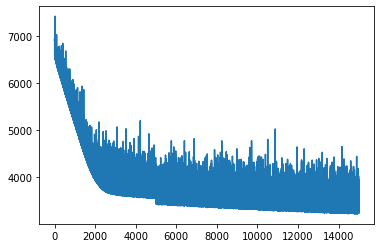

In [76]:
plt.plot([x['val_loss'] for x in history1+history2])


Let's log the final validation loss to Jovian and commit the notebook

In [78]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [79]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "quentinmadura/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/quentinmadura/02-insurance-linear-regression


'https://jovian.ml/quentinmadura/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [183]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [184]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([54.0000,  1.0000, 24.5817,  2.0000,  0.0000,  2.0000])
Target: tensor([11123.8486])
Prediction: tensor([12207.9150])


In [185]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([55.0000,  1.0000, 32.3447,  0.0000,  0.0000,  1.0000])
Target: tensor([10700.4463])
Prediction: tensor([11609.5430])


In [186]:
input, target = val_ds[50]
predict_single(input, target, model)

Input: tensor([33.0000,  1.0000, 41.8275,  2.0000,  0.0000,  2.0000])
Target: tensor([4938.8994])
Prediction: tensor([5564.7515])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

# Curated list of resources:
## Epoch vs iterations vs batch size
Towards Data Science - SAGAR SHARMA
https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9
Comprendre le deep learning: Une introduction aux réseaux de neurones - Jean-Claude Heudin 
https://www.amazon.com/Comprendre-Deep-Learning-introduction-neurones/dp/B01MSFLMFD